In [11]:
import numpy as np
import astropy.units as u
import astropy.constants as const
import Dorian
import matplotlib as mpl
from matplotlib import pyplot as plt

new_rcParams = {
    'figure.dpi': 150
}
mpl.rcParams.update(new_rcParams)

Set the parameters you wish to vary. For my work on L43E, these are the filliang fraction, the total optical depth, and the integrated intensity of $^{15}\text{NH}_2\text{D}$.

In [2]:
mu_f = 0.435
mu_tau = 3.54
sig_f = 0.12
sig_tau = 5.4e-2
mu_I15 = 0.005868
sig_I15 = 0.001292

#pick number of iterations
n = 1000

#create Gaussian distributions
dist = np.random.normal((mu_f, mu_tau, mu_I15), (sig_f, sig_tau, sig_I15), (n, 3))

Next we create the Molecule and objects, which will stay constant throughout the Monte Carlo draw.

In [3]:
mol15 = Dorian.Molecule('15NH2D_lvls.csv', ortho_g = 3)
mol14 = Dorian.Molecule('onh2d_lvls.csv', ortho_g = 7, relative_intensity = 14/81)

Then we call Dorian and loop over n, drawing random values and calculating the fractionation ratio at each one.

In [4]:
output = np.zeros(n)
i = 0
for f, tau, I15 in dist:

    obs14 = Dorian.Observation(85.926278e9*u.Hz, 1.507*u.K, 0.76964*u.km/u.s, 'calculate', 
                           filename = 'onh2d.txt', vlsr = 0.75*u.km/u.s, dv = 0.325*u.km/u.s,
                           Eu_k = 20.0894*u.K, tau_main = tau, eff_MB = 0.92, fill_frac = f, 
                           Einstein_A = 5.23e-6/u.s, Int_R = 14/81)
    
    Tex14, n14 = Dorian.ColumnDensity(mol14, obs14)

    #the limits of the uniform random draw are derived from RADEX simulations particular to L43E
    #see my notebook RADEX_Example
    
    Tex15 = np.random.uniform(0.7*Tex14.value, 0.8*Tex14.value)
    
    obs15 = Dorian.Observation(nu = 86.4199959e9*u.Hz, TA_star = I15*u.K, Tex = Tex15*u.K, 
                               Eu_k = 20.6247*u.K,
                           dipole = 1.463e-18, S = 1.5, eff_MB = 0.92, fill_frac = f)

    n15 = Dorian.ColumnDensity(mol15, obs15, opt_thin = True)

    ratio = n14.value/n15.value

    output[i] = ratio

    #give a little update!
    if i % 1000 == 0:
        print(i)
    i += 1

0


Let's figure out our percentiles...

In [5]:
sigma = np.std(output)
mu = np.median(output)
sorted = np.sort(output)
lower_1sig = sorted[int(np.round(0.165*n, 0))]
upper_1sig = sorted[int(np.round(0.835*n, 0))]
lower_2sig = sorted[int(np.round(0.025*n, 0))]
upper_2sig = sorted[int(np.round(0.975*n, 0))]

...and plot our results!

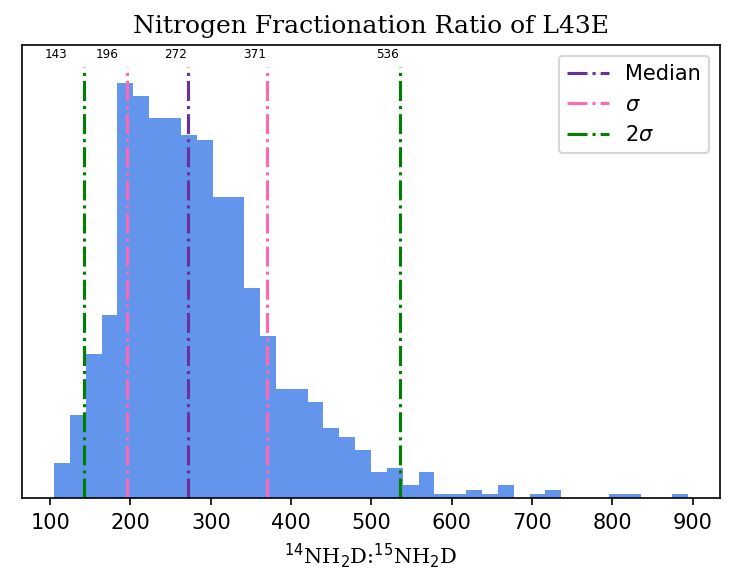

In [13]:
count, bins, ignored = plt.hist(output, int(n/25), density=True, color = 'cornflowerblue')
plt.vlines(x = np.median(output), ymin = 0, ymax = 0.005, color = 'rebeccapurple', linestyles = 'dashdot', 
           label = 'Median')
plt.vlines(lower_1sig, ymin = 0, ymax = 0.005, color = 'hotpink', linestyles = 'dashdot', 
           label = r'$\sigma$')
plt.vlines(upper_1sig, ymin = 0, ymax = 0.005, color = 'hotpink', linestyles = 'dashdot')
plt.vlines(lower_2sig, ymin = 0, ymax = 0.005, color = 'green', linestyles = 'dashdot', 
           label = r'$2\sigma$')
plt.vlines(upper_2sig, ymin = 0, ymax = 0.005, color = 'green', linestyles = 'dashdot')
plt.legend()
plt.text(lower_2sig-50, 0.0051, str(int(np.round(lower_2sig, 0))), fontsize = 'xx-small')
plt.text(lower_1sig-40, 0.0051, str(int(np.round(lower_1sig, 0))), fontsize = 'xx-small')
plt.text(mu-30, 0.0051, str(int(np.round(mu, 0))), fontsize = 'xx-small')
plt.text(upper_1sig-30, 0.0051, str(int(np.round(upper_1sig, 0))), fontsize = 'xx-small')
plt.text(upper_2sig-30, 0.0051, str(int(np.round(upper_2sig, 0))), fontsize = 'xx-small')
plt.title('Nitrogen Fractionation Ratio of L43E', family = 'serif')
plt.xlabel(r'$^{14}$NH$_2$D:$^{15}$NH$_2$D', family = 'serif')
plt.yticks([])
plt.show()